In [ ]:
import numpy as np
import cv2 # b, g, r
import matplotlib.pyplot as plt
from PIL import Image # r, g, b
from sklearn.decomposition import PCA

In [ ]:
!gdown --id 1hjrsv9NAZGP4BMN98FBn5ZKADaLXQbzG -O imgs.zip
!gdown --id 1zGbBpJflQtVDzm2fTPQegKocizD6EEDF -O imgs_gt.zip
!unzip -q imgs.zip
!unzip -q imgs_gt.zip
!rm imgs.zip
!rm imgs_gt.zip

Downloading...
From: https://drive.google.com/uc?id=1hjrsv9NAZGP4BMN98FBn5ZKADaLXQbzG
To: /content/imgs.zip
933MB [00:07, 127MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1zGbBpJflQtVDzm2fTPQegKocizD6EEDF
To: /content/imgs_gt.zip
155MB [00:01, 87.5MB/s]


In [ ]:
import os
os.mkdir("imgs")
os.mkdir("imgs_gt") 

In [ ]:
for index in range(1, 40):
  img = Image.open(f'./{index}_F.JPG').resize((256,256))
  img_groundTruth = Image.open(f'./{index}.JPG').resize((256,256))
  img_groundTruth = img_groundTruth.crop((0,0,200,200))
  img = img.crop((0,0,200,200))
  img.save(f"./imgs/{index}_F.JPG")
  img_groundTruth.save(f"./imgs_gt/{index}.JPG")

In [ ]:
!zip -r ./imgs.zip ./imgs
!zip -r ./imgs_gt.zip ./imgs_gt

  adding: imgs/ (stored 0%)
  adding: imgs/23_F.JPG (deflated 4%)
  adding: imgs/10_F.JPG (deflated 4%)
  adding: imgs/29_F.JPG (deflated 1%)
  adding: imgs/17_F.JPG (deflated 2%)
  adding: imgs/9_F.JPG (deflated 2%)
  adding: imgs/27_F.JPG (deflated 4%)
  adding: imgs/1_F.JPG (deflated 2%)
  adding: imgs/11_F.JPG (deflated 1%)
  adding: imgs/2_F.JPG (deflated 2%)
  adding: imgs/32_F.JPG (deflated 2%)
  adding: imgs/8_F.JPG (deflated 2%)
  adding: imgs/21_F.JPG (deflated 2%)
  adding: imgs/20_F.JPG (deflated 2%)
  adding: imgs/35_F.JPG (deflated 3%)
  adding: imgs/30_F.JPG (deflated 3%)
  adding: imgs/25_F.JPG (deflated 2%)
  adding: imgs/4_F.JPG (deflated 1%)
  adding: imgs/33_F.JPG (deflated 2%)
  adding: imgs/26_F.JPG (deflated 6%)
  adding: imgs/14_F.JPG (deflated 1%)
  adding: imgs/3_F.JPG (deflated 1%)
  adding: imgs/15_F.JPG (deflated 3%)
  adding: imgs/28_F.JPG (deflated 2%)
  adding: imgs/7_F.JPG (deflated 1%)
  adding: imgs/13_F.JPG (deflated 2%)
  adding: imgs/24_F.JPG (defl

In [ ]:
!rm -r ./*.JPG

In [ ]:
from google.colab import files
files.download("./imgs.zip")
files.download("./imgs_gt.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def srgb2xyz(img_array):
    sRGBtoXYZ = np.array([[0.4124564,  0.3575761,  0.1804375],
                         [0.2126729,  0.7151522,  0.0721750],
                         [0.0193339,  0.1191920,  0.9503041]])
    h, w, channel = img_array.shape
    new_img = np.zeros(shape=img_array.shape, dtype = np.float32)
    
    for i in range(h):
        for j in range(w):
            new_img[i,j,:] = np.matmul(sRGBtoXYZ, img_array[i,j,:])
    
    return new_img

def xyz2srgb(img_array):
    sRGBtoXYZ = np.array([[0.4124564,  0.3575761,  0.1804375],
                         [0.2126729,  0.7151522,  0.0721750],
                         [0.0193339,  0.1191920,  0.9503041]])
    XYZtosRGB = np.linalg.inv(sRGBtoXYZ)
    h, w, channel = img_array.shape
    new_img = np.zeros(shape=img_array.shape, dtype = np.float32)
    
    for i in range(h):
        for j in range(w):
            new_img[i,j,:] = np.matmul(sRGBtoXYZ, img_array[i,j,:])
    
    return new_img

def GrayWorld(img):
    img_array = np.array(img)
    R_avg = np.mean(img_array[:,:,0])
    G_avg = np.mean(img_array[:,:,1])
    B_avg = np.mean(img_array[:,:,2])
    
    Gray = (R_avg + G_avg + B_avg) / 3
    RGB_avg = [R_avg, G_avg, B_avg]
    scaledVal = Gray / RGB_avg
    
    new_img = np.zeros(shape=img_array.shape, dtype = np.float32)
    
    for index, val in enumerate(scaledVal):
        new_img[:,:,index] = img_array[:,:,index] * val
    
    new_img[new_img > 255] = 255
    
    return Image.fromarray(new_img.astype(np.uint8))

def WhitePatchRetinex(img):
    img_array = np.array(img)
    h, w, colorChannel = img_array.shape
    new_img = np.zeros(shape=img_array.shape, dtype = np.float32)
    color = ['r', 'g', 'b']
    pn = 0.1 * h * w 
    plt.figure()
    for i in range(colorChannel):
        img_hist = cv2.calcHist([img_array], [i], None, [256], [0, 256])
        plt.plot(range(256), img_hist, label=color[i], color=color[i])
        plt.legend(loc='best')
        plt.title('Histogram')
        Li = 256 # The intensity of light source to be calculated
        Sum = 0
        while Sum < pn and Li > 1:
            Li -= 1
            Sum += img_hist[Li]
        new_img[:,:,i] = img_array[:,:,i] / (Li / 255)
        new_img[new_img > 255] = 255
        
    return Image.fromarray(new_img.astype(np.uint8))

def ChengPCA(img):
    img_array = np.array(img)
    new_img = np.zeros(shape=img_array.shape, dtype = np.float32)
    h, w, colorChannel = img_array.shape
    R_avg = np.mean(img_array[:,:,0])
    G_avg = np.mean(img_array[:,:,1])
    B_avg = np.mean(img_array[:,:,2])
    
    wp_d65 = np.array([0.95047, 1.0000, 1.08883])
    # wp_d65 = [1, 1, 1]
    wp_d65 = wp_d65 / np.linalg.norm(wp_d65)
    
    
    n = round(0.035 * h * w)  # choose top and bottom 3.5% pixels
    I_0 = np.array([R_avg, G_avg, B_avg])
    I_0_norm = np.linalg.norm(I_0)
    
    d_matrix = np.zeros(shape=[h, w], dtype = np.float32)
    for i in range(h):
        for j in range(w):
            pixel = img_array[i,j,:]
            pixel_norm = np.linalg.norm(pixel)
            d_matrix[i,j] = np.dot(pixel, I_0) / (pixel_norm * I_0_norm) 
            
    dSort = d_matrix.reshape(h*w)
    top_threshold = dSort[-n]
    bottom_threshold = dSort[n]
    top_select = np.argwhere(d_matrix >= top_threshold)
    bottom_select = np.argwhere(d_matrix <= bottom_threshold)
    select = np.concatenate((bottom_select, top_select), axis=0)
    data = []
    for i, j in select:
        data.append(img_array[i,j,:])

    n_components = 2
    random_state = 9527

    pca = PCA(n_components=n_components, 
              random_state=random_state)
    L = pca.fit_transform(np.array(data)/1)
    pcs = np.array(pca.components_) # (n_comp, n_features)
    scaleVal = abs(pcs[0])
    for i in range(colorChannel):
        new_img[:,:,i] = img_array[:,:,i] * (wp_d65[i] / scaleVal[i]) 
    
    new_img[new_img > 255] = 255
        
    return Image.fromarray(new_img.astype(np.uint8))


def visualization(imgs_before, imgs_GrayWorld, imgs_WhitePatchRetinex, imgs_ChengPCA, imgs_groundTruth):
    
    for index in range(len(imgs_before)):
        names = ['Before', 'GrayWorld', 'WhitePatchRetinex', 'ChengPCA', 'Ground Truth']
        imgs_show = [imgs_before[index], imgs_GrayWorld[index], imgs_WhitePatchRetinex[index], imgs_ChengPCA[index], imgs_groundTruth[index]]
        plt.figure(figsize=(15, 40))
        for i in range(5):
            plt.subplot(1,5,i+1)
            im = imgs_show[i]
            plt.title(names[i])
            plt.imshow(im)


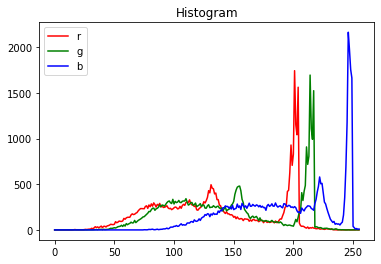

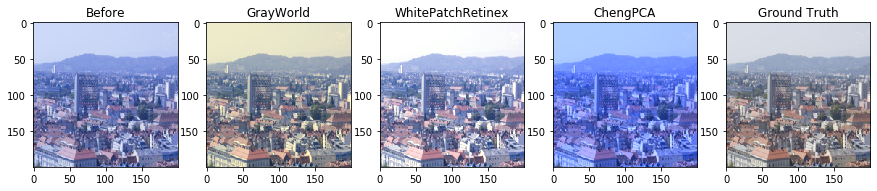

In [ ]:
index = 3 # succeed:38,  |fail:35, 36
inputImg_dir = './Dataset/Cube_input_images'
groundTruth_dir = './Dataset/Cube_ground_truth_images'
img = Image.open(f'{inputImg_dir}/{index}.JPG').resize((256,256))
img_groundTruth = Image.open(f'{groundTruth_dir}/{index}.JPG').resize((256,256))
img_groundTruth = img_groundTruth.crop((0,0,200,200))
img = img.crop((0,0,200,200))

imgs_before = [img]
imgs_GrayWorld = [GrayWorld(img)]
imgs_WhitePatchRetinex = [WhitePatchRetinex(img)]
imgs_ChengPCA = [ChengPCA(img)]
imgs_groundTruth = [img_groundTruth]

visualization(imgs_before, imgs_GrayWorld, imgs_WhitePatchRetinex, imgs_ChengPCA, imgs_groundTruth)